In [167]:
import pandas as pd
import os
from os.path import join
import numpy as np
import mne
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)

import h5py
from os.path import join as opj
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import tqdm
from versatile_diffusion_dual_guided_fake_images import *
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from torchsummary import summary

In [2]:
def get_dataset(p):
    preproc_dir="/home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/"
    epochs = mne.read_epochs(f'{preproc_dir}/preprocessed_P{str(p)}-epo.fif', preload=False)

    train_data=epochs[epochs.metadata["trial_type"] == "exp"]
    test_data=epochs[epochs.metadata["trial_type"] == "test"]
    #try to load images

    stimuli_path=opj("/home/matteo/data/THINGS_img/THINGS","Images")

    img_class=train_data.metadata.image_path.iloc[0].split("images_meg/")[-1].split("/")[0]
    img_name=train_data.metadata.image_path.iloc[0].split("images_meg/")[-1].split("/")[1]

    # Image.open(opj(stimuli_path,img_class,img_name))

    img_train=[opj(stimuli_path,img_class,img_name) for img_class,img_name in zip(train_data.metadata.image_path.str.split("images_meg/").str[0],train_data.metadata.image_path.str.split("images_meg/").str[1])]

    test_data.metadata.image_path.iloc[0].split("images_test_meg/")[-1]

    img_test=[]
    for i in range(len(test_data.metadata)):
        filename=test_data.metadata.image_path.iloc[i].split("images_test_meg/")[-1]
        img_class=filename[:filename.rfind("_")]
        img_test.append(opj(stimuli_path,img_class,filename))

    train_metadata=train_data.metadata
    test_metadata=test_data.metadata

    return img_train,img_test,train_data.get_data(),test_data.get_data(),train_metadata,test_metadata


In [2]:
# img_train,img_test,train_data,test_data,train_metadata,test_metadata=get_dataset(1)

In [3]:
train_datas=[]
test_datas=[]
train_metadatas=[]
test_metadatas=[]
img_train=[]
img_test=[]
subject_train_ids=[]
subject_test_ids=[]

for p in tqdm.trange(1,5):
    img_train_,img_test_,train_data_,test_data_,train_metadata_,test_metadata_=get_dataset(p)
    img_train+=img_train_
    img_test+=img_test_
    train_datas.append(train_data_)
    test_datas.append(test_data_)
    train_metadatas.append(train_metadata_)
    test_metadatas.append(test_metadata_)
    subject_train_ids+=[p]*len(train_metadata_)
    subject_test_ids+=[p]*len(test_metadata_)

  0%|                                                                                                                                           | 0/4 [00:00<?, ?it/s]

Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P1-epo-3.fif ...
    Found

 25%|████████████████████████████████▊                                                                                                  | 1/4 [00:07<00:23,  7.70s/it]

Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P2-epo-3.fif ...
    Found

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [00:17<00:18,  9.08s/it]

Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P3-epo-3.fif ...
    Found

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [00:27<00:09,  9.17s/it]

Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/matteo/data/THINGS_MEG/LOCAL/ocontier/thingsmri/openneuro/THINGS-data/THINGS-MEG/ds004212/derivatives/preprocessed/preprocessed_P4-epo-3.fif ...
    Found

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.07s/it]


In [4]:
train_data=np.concatenate(train_datas)
test_data=np.concatenate(test_datas)
train_metadata=pd.concat(train_metadatas)
test_metadata=pd.concat(test_metadatas)


In [5]:
train_data.shape, len(img_train)

((88992, 271, 281), 88992)

In [6]:
88992//64

1390

## Create dataset

In [7]:
batch=256
device="cuda:0"

pipe_embed = VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline.from_pretrained("shi-labs/versatile-diffusion", )

pipe_embed.remove_unused_weights()
pipe_embed = pipe_embed.to(device)

Fetching 17 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 72907.12it/s]


In [ ]:
train_clip_img_embeds=[]


with torch.no_grad():
    for i in tqdm.tqdm(range(0,len(img_train),batch)):

        #save img data
        y= img_train[i:i+batch]
                         
        images=[Image.open(i).convert("RGB") for i in y]

        #encode images in CLIP
        image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
        train_clip_img_embeds.append(image_features)

    
        
    train_clip_img_embeds = torch.cat(train_clip_img_embeds,axis=0)



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 342/348 [51:09<00:50,  8.44s/it]

In [ ]:

test_clip_img_embeds=[]
with torch.no_grad():
    for i in tqdm.tqdm(range(0,len(img_test),batch)):

        #save img data
        y= img_test[i:i+batch]
                         
        images=[Image.open(i).convert("RGB") for i in y]

        #encode images in CLIP
        image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
        test_clip_img_embeds.append(image_features)

    
        
    test_clip_img_embeds = torch.cat(test_clip_img_embeds,axis=0)
    

In [334]:
os.makedirs("data_meg",exist_ok=True)

#save everything

np.save("data_meg/train_data.npy",train_data)
np.save("data_meg/test_data.npy",test_data)



In [18]:
np.save("data_meg/train_clip_img_embeds.npy",train_clip_img_embeds[:,0])
np.save("data_meg/test_clip_img_embeds.npy",test_clip_img_embeds[:,0])

train_metadata.to_csv("data_meg/train_metadata.csv")
test_metadata.to_csv("data_meg/test_metadata.csv")

np.save("data_meg/subject_train_ids.npy",np.array(subject_train_ids))
np.save("data_meg/subject_test_ids.npy",np.array(subject_test_ids))


[array([[[ 1.57707201,  0.53701778,  0.15192282, ...,  0.16624991,
          -0.35987433, -1.67876821],
         [ 1.94680107,  1.68643402,  1.35182972, ..., -1.33275795,
          -1.53056816, -2.28966982],
         [ 1.29372525,  1.30624025,  1.16855759, ..., -1.03669897,
          -0.88301681, -1.19979538],
         ...,
         [-0.32812272, -0.87816334, -1.13376141, ...,  0.30765004,
           0.20887651,  0.17419926],
         [-1.14870903, -1.46220451, -1.6627655 , ...,  0.18938119,
          -0.07458352, -0.17221385],
         [ 1.39359119,  0.79016237,  0.11873742, ...,  0.41142461,
           0.73032364,  1.40944141]],
 
        [[-0.39645245, -0.05687432,  0.61257203, ...,  2.68583821,
           2.16672932,  1.54352776],
         [-1.11679675, -0.08382776,  1.28096867, ...,  2.8550732 ,
           2.24875701,  1.92515316],
         [-1.11838725, -0.15888634,  1.22533427, ...,  2.23334301,
           2.05332733,  1.79318058],
         ...,
         [ 1.47348835,  1.6167982

## Dataset

In [23]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(),train_clip_img_embeds[:,0], torch.tensor(subject_train_ids))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(),test_clip_img_embeds[:,0], torch.tensor(subject_test_ids))


In [25]:
x,y,idx=train_dataset[0]    



BS=256

clip_train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
clip_test_dataloader=DataLoader(test_dataset, batch_size=BS, shuffle=False)

x.shape, y.shape

(torch.Size([271, 281]), torch.Size([768]))

## Model

In [137]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU, alignment_layers_keys=[1,2,3,4]):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        
        self.alignment_layers={}
        for k in alignment_layers_keys:
            self.alignment_layers[k]=nn.Conv1d(num_input_channels, num_input_channels, kernel_size=11, padding=5, stride=1)
        
        self.net = nn.Sequential(
            nn.Conv1d(num_input_channels, c_hid, kernel_size=11, padding=1, stride=3),  # 32 => 16
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=1,stride=2),
            act_fn(),
            nn.Conv1d(c_hid, 2 * c_hid, kernel_size=5, padding=1, stride=2),  # 16 => 8
            act_fn(),
            nn.Conv1d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1,stride=2),
            act_fn(),
            nn.Conv1d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8 => 4
            act_fn(),
            nn.Conv1d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 4 => 2
            act_fn(),
            nn.Flatten(),  # Sequence to single feature vector
            nn.LazyLinear(latent_dim),
        )

        
    def _apply(self, fn):
        super(Encoder, self)._apply(fn)        
        for k,v in self.alignment_layers.items():
            self.alignment_layers[k]._apply(fn)
            
    
    def forward(self, x, k=None):
        
        def apply_alignment_layers(x, k, alignment_layers):
            # Create an empty tensor to store the results
            result = torch.empty_like(x)
            
            # Iterate through each unique key in k
            for key in k.unique():
                # Create a mask for all elements that match the current key
                mask = (k == key.item())
                
                # Apply the corresponding alignment layer to the masked elements
                result[mask] = alignment_layers[key.item()](x[mask])
            
            assert result.shape==x.shape
            return result
        
        if k is None:
            k=torch.ones(len(x))
        # Apply alignment layers to x using the custom function
        x = apply_alignment_layers(x, k, self.alignment_layers)
        
        # x = self.alignment_layers[k](x)
        return self.net(x)

In [140]:
# model = Encoder(num_input_channels= 271, base_channel_size=192, latent_dim=768,act_fn=nn.ReLU)


# model.to(device)

# x= torch.randn(2,271,281)
# k= torch.tensor([1,2])

# model(x.to(device),k=k.to(device))

In [141]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class ContrastiveModel(pl.LightningModule):

    def contrastive_loss(self, z_i, z_j):

        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        logits = (z_i @ z_j.T) / self.temperature
        similarities = z_j @ z_j.T
        # targets = torch.nn.functional.softmax(similarities * self.temperature, dim=-1)

        targets = torch.arange(logits.shape[0]).long().to(logits.device)
        
        loss = torch.nn.functional.cross_entropy(logits, targets)
        return loss
    
    
    def init_subjective_layers(self,x,keys):
        k=torch.tensor(keys)
        self(torch.zeros(4,x.shape[1],x.shape[2]),k=k)
    
    def mean_contrastive(self, z_i, z_j, temperature=1.0):
        return nn.functional.mse_loss(z_i, z_j)+self.contrastive_loss(z_i, z_j, temperature=temperature)/8
    
    def cosine_loss(self, z_i, z_j, temperature=1.0):
        cosine_similarity = torch.nn.functional.cosine_similarity(z_i, z_j).mean()
        return 1- cosine_similarity

    def __init__(self,  num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU, temperature=.1,loss_type="contrastive"):
        super().__init__()
        
        self.temperature=temperature
        
        self.model = Encoder(num_input_channels, base_channel_size, latent_dim, act_fn)

        self.loss_type=loss_type
        if loss_type=="contrastive":
            self.loss_fn=self.contrastive_loss
        elif loss_type=="mean_contrastive":
            self.loss_fn=self.mean_contrastive
        
        elif loss_type=="mse":
            self.loss_fn=torch.nn.functional.mse_loss
        elif loss_type=="cosine":
            self.loss_fn=self.cosine_loss
        
        self.train_losses = []
        self.train_mse=[]
        self.train_cosine=[]
        self.val_losses = []
        self.val_mse=[]
        self.val_cosine=[]
    
    def forward(self, x, **kwargs):
        return self.model(x,**kwargs)
    
    def training_step(self, batch, batch_idx):
        x, y,idx= batch
        # x = x.float()
        y_hat = self(x,k=idx)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.train_losses.append(loss.item())

        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.train_mse.append(mse_loss.item())
        self.train_cosine.append(cosine_similarity.item())

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        
        x, y, idx= batch
        # x = x.float()

        y_hat = self(x,k=idx)

        loss=self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        
        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log('val_mse_loss', mse_loss, on_epoch=True, prog_bar=True)
        
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.log('val_cosine_similarity', cosine_similarity, on_epoch=True, prog_bar=True)
        
        self.val_losses.append(loss.item())
        self.val_mse.append(mse_loss.item())
        self.val_cosine.append(cosine_similarity.item())
        return mse_loss
        
    def configure_optimizers(self):
        # return torch.optim.AdamW(self.parameters(), lr=3e-4, weight_decay=0)
        # add a scheduler
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        # use a scheduler that every 100 steps, it will reduce the learning rate by 0.1
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}



In [142]:
# # brain_model.model.alignment_layers[1][0]
# optim=torch.optim.AdamW(brain_model.parameters())

# optim.param_groups[0]["params"][0].shape

In [144]:
brain_model = ContrastiveModel(num_input_channels= 271, base_channel_size=192, latent_dim=768,act_fn=nn.ReLU, loss_type="contrastive")
# brain_model.init_subjective_layers(x,keys=[1,2,3,4])
# summary(brain_model, x.shape,device="cpu")

In [146]:
# brain_model.device

In [92]:
# brain_model(x,k=k)

In [ ]:


# Instantiate a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=30, devices=[0])

# Train the model
trainer.fit(brain_model, clip_train_dataloader, clip_test_dataloader)

{1, 2, 3, 4}

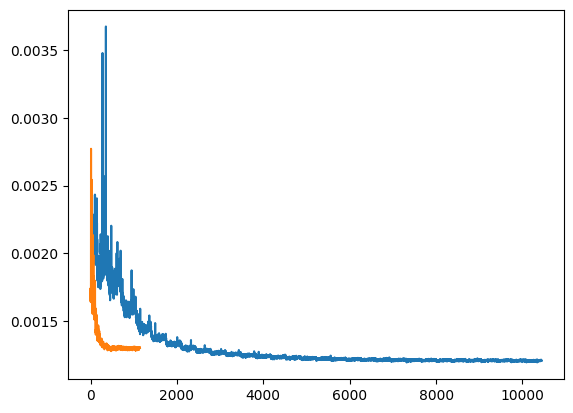

In [148]:
plt.plot(brain_model.train_mse, label='train')
plt.plot(brain_model.val_mse, label='val')

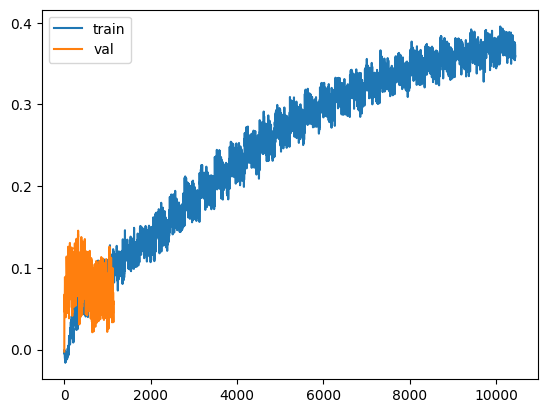

In [149]:
plt.plot(brain_model.train_cosine, label='train')
plt.plot(brain_model.val_cosine, label='val')
plt.legend()

In [152]:
x,y,k=next(iter(clip_test_dataloader))

y_pred=[]
with torch.no_grad():

    for x,y,k in tqdm.tqdm(clip_test_dataloader):
        y_hat=brain_model(x,k=k).cpu()
        y_pred.append(y_hat)

y_pred=torch.cat(y_pred,0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.78it/s]


In [154]:
test_data.shape

(9600, 271, 281)

In [160]:
# similarity=  torch.nn.functional.softmax(.1*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred,.1).T)

z_i=y_pred
z_j=test_clip_img_embeds[:,0]

z_i = nn.functional.normalize(z_i, dim=1)
z_j = nn.functional.normalize(z_j, dim=1)

logits = (z_i @ z_j.T) / .1

similarity =  torch.nn.functional.softmax(logits,-1)
top_indices=torch.topk(similarity,500,1).indices
# similarity=  torch.nn.functional.softmax(10*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred.T,-1))

In [ ]:
# top_indices

In [161]:
## voglio selezionare immagini diverse!
selected_images=[]
for top_idxs in tqdm.tqdm(top_indices):
    selected_images.append(list(set(np.array(img_test)[top_idxs])))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:13<00:00, 726.02it/s]


In [169]:
#measure accuracy
selected_classes=[]
for top_sel_imgs in selected_images:
    selected_classes.append([i.split("Images/")[1].split("/")[0] for i in top_sel_imgs])

selected_classes=np.array(selected_classes)

In [165]:
metadata_df=test_metadata
classes=np.array([metadata_df["image_path"].iloc[idx].split("images_test_meg/")[1].split("_")[0] for idx in range(len(metadata_df))])
test_classes=classes


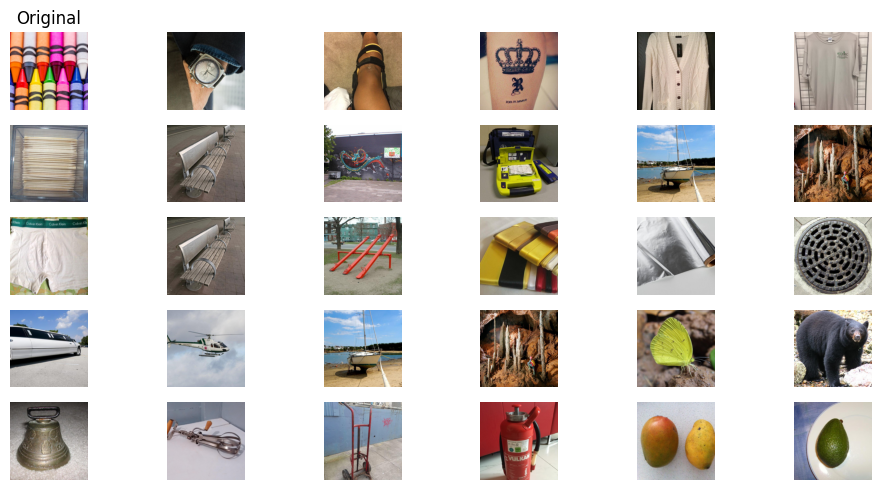

In [162]:
idx=0
fig, ax = plt.subplots(5,6,figsize=(10,5))  


for i in range(5):
    ax[i,0].imshow(Image.open(img_test[idx+i]).convert("RGB").resize((224,224)))
    ax[i,1].imshow(Image.open(selected_images[idx+i][0]).convert("RGB").resize((224,224)))

    ax[i,2].imshow(Image.open(selected_images[idx+i][1]).convert("RGB").resize((224,224)))
    ax[i,3].imshow(Image.open(selected_images[idx+i][2]).convert("RGB").resize((224,224)))
    ax[i,4].imshow(Image.open(selected_images[idx+i][3]).convert("RGB").resize((224,224)))

    ax[i,5].imshow(Image.open(selected_images[idx+i][4]).convert("RGB").resize((224,224)))

    ax[i,0].axis("off")
    ax[i,1].axis("off")
    ax[i,2].axis("off")
    ax[i,3].axis("off")
    ax[i,4].axis("off")
    ax[i,5].axis("off")

ax[0,0].set_title("Original")   


plt.tight_layout()


In [338]:
os.makedirs(f"models_contrastive_MEG_all",exist_ok=True)

torch.save(brain_model, "models_contrastive_MEG_all/whole_pl_model.pt")
torch.save(brain_model.state_dict(), "models_contrastive_MEG_all/whole_pl_model_state_dict.pt")

torch.save(brain_model.model, "models_contrastive_MEG_all/encoder.pt")
torch.save(brain_model.model.state_dict(), "models_contrastive_MEG_all/encoder_state_dict.pt")

#save individually alignment layers
## check
#save individually all keys
for k in brain_model.model.alignment_layers.keys():
    torch.save(brain_model.model.alignment_layers[k].state_dict(),f"models_contrastive_MEG_all/alignment_layers_{k}_state_dict.pt")



In [337]:
torch.save(test_clip_img_embeds,"models_contrastive_MEG_all/test_clip_img_embeds.pt")

In [170]:
# compute accuracy

top1_accuracy=accuracy_score(test_classes,selected_classes[:,0])


#compute accuracy for top 5
top5_accuracy=[]
for i in range(len(test_classes)):
    if test_classes[i] in selected_classes[i,:5]:
        top5_accuracy.append(1)
    else:
        top5_accuracy.append(0)

top5_accuracy=np.mean(top5_accuracy)

top1_accuracy,top5_accuracy

(0.012083333333333333, 0.06135416666666667)

## 27 high level categories

In [253]:
import re

In [171]:
categories=pd.read_csv("/data01/data/THINGS_img/THINGS/27 higher-level categories/category_mat_manual.tsv"   ,sep="\t")
categorization=pd.read_csv("/data01/data/THINGS_img/THINGS/27 higher-level categories/categorization.tsv",sep="\t",header=None)
categorization

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,aardvark,aardvark,animal,animal,animal,animal,animal,animal,animal,animal,...,animal,animal,animal,animal,animal,animal,animal,animal,anteater,mammal
1,abacus,academics,calculating tool,calculator,calculator,calculators,counting,counting device,game,instrument,...,math tool,math tool,math tool,mathematic,mathematic tool,mathematical device,mathematical device,mathematics,science instrument,tool
2,accordion,music,music,music equipment,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument,...,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument,musical instrument
3,acorn,acorn,fruit,fruit,nut,nut,nut,nut,nut,nut,...,nut,plant,seed,seed,seed,seed,squirrel meal,tree nut,tree seed,wooden
4,air conditioner,air,appliance,appliance,appliance,appliance,appliance,appliance,cooling,cooling system,...,home,home appliance,home appliance,home appliance,home furnishing,household appliance,household climate control,hvac,portable cooling units,temperature controller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,yoke,animal control,animal harness,cowboy,farm,farm equipment,farm equipment,farming,farming equipment,farming equipment,...,harness,harness,harvest tool,horse supply,joiner,ox,plow equipment,plowing need,tool,tool
1850,yolk,ingredient,baking,breakfast,dairy,dairy,egg,egg,egg middle,egg part,...,eggs,food,food,food,food,food,ingredient,part of egg,part of egg,part of egg
1851,zebra,african animal,african mammal,animal,animal,animal,animal,animal,animal,animal,...,animal,animal,animal,animal,equid,equid,large animal,mammal,striped horse,zoo animal
1852,zipper,close,closure,clothing,clothing,clothing,clothing,clothing,coat,device,...,fastener,part of clothing,part of clothing,part of pants,seamstress essential,sewing,sewing supply,tool,tool,tool


In [215]:
# train_metadata

i=0
train_metadata.image_path.iloc[i].split("/")[1]


'vest'

In [217]:
# train_metadata

In [218]:
train_classes=[train_metadata.image_path.iloc[i].split("/")[1] for i in range(len(train_metadata))]
test_classes=[test_metadata.image_path.iloc[i].split("/")[1][:test_metadata.image_path.iloc[i].split("/")[1].rfind("_")] for i in range(len(test_metadata))]


In [258]:
test_classes=[re.sub(r'\d', '', s) for s in test_classes]


In [228]:
train_cat_indices=[]
test_cat_indices=[]

for i in tqdm.trange(len(train_classes)):
    try:
        idx=categorization[categorization[0]==train_classes[i]].index[0]
    except:
        try:
            idx=categorization[categorization[1]==train_classes[i]].index[0]
        except:
            pass

    train_cat_indices.append(idx)
    



  0%|                                                                                                                              | 2/9600 [00:00<00:03, 2481.10it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [300]:
test_cat_indices=[]

for i in tqdm.trange(len(test_classes)):
    
    idx=categorization[categorization[0]==test_classes[i].replace("_", " ")].index[0]
    test_cat_indices.append(idx)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:02<00:00, 4521.81it/s]


In [301]:
train_categories=categories.iloc[train_cat_indices].values.argmax(axis=1)
test_categories=categories.iloc[test_cat_indices].values.argmax(axis=1)


In [314]:
train_labels=categories.columns[train_categories]
test_labels=categories.columns[test_categories]


len(test_labels)

9600

In [311]:
selected_test_labels=[]

for i in range(len(top_indices)):
    selected_test_labels.append(test_labels[top_indices[i]][:5].values)

selected_test_labels=np.array(selected_test_labels)

In [329]:
### metrics on high-level categories

cat_acc=accuracy_score(test_labels,selected_test_labels[:,0])

#compute accuracy for top 5
cat_top5_accuracy=[]
for i in range(len(test_labels)):
    if test_labels[i] in selected_test_labels[i,:5]:
        cat_top5_accuracy.append(1)
    else:
        cat_top5_accuracy.append(0)

cat_top5_accuracy=np.mean(cat_top5_accuracy)
cat_acc,cat_top5_accuracy

(0.18541666666666667, 0.479375)

In [328]:
# 3/27